In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
rng = np.random.default_rng(12345)

inf_list = ['xs', 'ys', 'zs', 'r_s', 'l_t']
number_samples = 1000

xs = np.full((number_samples,1), 0.) if 'xs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
ys = np.full((number_samples,1), 0.) if 'ys' not in inf_list else rng.uniform(low=-2000, high=5000, size=(number_samples,1))
zs = np.full((number_samples,1), 50.) if 'zs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
alphas = np.full((number_samples,1), 0.) if 'alphas' not in inf_list else rng.uniform(low=-(np.pi / 3), high=(np.pi / 3), size=(number_samples,1))
hs = np.full((number_samples,1), 1.) if 'hs' not in inf_list else rng.uniform(low=-1., high=1., size=(number_samples,1))
phis = np.full((number_samples,1), 0.) if 'phis' not in inf_list else rng.uniform(low=0, high=np.pi, size=(number_samples,1))
loc_param = np.concatenate((xs, ys, zs, alphas, hs, phis), axis=1)

r_s = np.full((number_samples,1), 6.0) if 'r_s' not in inf_list else rng.normal(loc=((np.log(3) + np.log(12)) / 2), scale=((np.log(12) - np.log(3)) / 6), size=(number_samples,1))
l_t = np.full((number_samples,1), 400.0) if 'l_t' not in inf_list else rng.uniform(low=20., high=800., size=(number_samples,1))
r_t = np.full((number_samples,1), 0.5) if 'r_t' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r2_t = np.square(r_t)
clf = ClassifierBuilder()
clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
gmax = clf.predict(np.column_stack((r2_t, l_t)))
r_d = np.full((number_samples,1), 0.5) if 'r_d' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_tu = np.full((number_samples,1), 0.5) if 'r_tu' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
l_d = np.full((number_samples,1), 200.0) if 'l_d' not in inf_list else rng.normal(loc=((np.log(100) + np.log(300)) / 2), scale=((np.log(300) - np.log(100)) / 4), size=(number_samples,1))
geo_param = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)

# geo_param = [8,600.,1.25,.28,.28,200.]
# geo_param = np.tile(geo_param, (number_samples, 1))

labels = np.concatenate((xs, ys, zs, r_s, l_t), axis=1)#np.concatenate((loc_param, geo_param), axis=1)
np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(1000, 6)
(1000, 6)
(1000, 5)


In [3]:
hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

sim = Simulation(geometry = geo_standard, 
                 electrodes = params.ELECTRODE_POSITION, 
                 cell_type = CellTypes.ACTIVE, 
                 loc_param = loc_param, 
                 geo_param = geo_param, 
                 gmax = gmax, 
                 scale = 1., 
                 ncell = number_samples)
# sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
sec_list = sim.cells[0].all
dend_v = Recorder([sec_list[5](0.1),sec_list[5](0.5),sec_list[5](0.9),sec_list[6](0.5)])

In [4]:
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

lfp_list = []
summ_stat_list = []
sim.run_neuron_sim()

# lfp_list = sim.get_lfp(np.arange(number_samples, dtype=int)).T

for i in range(number_samples):
    lfp_list.append(sim.get_lfp(i).T)
    lfp_list[-1] /= np.max(np.abs(lfp_list[-1]))
#     print(lfp_list[-1].shape)
    fst_idx = first_pk_tr(lfp_list[-1])
    start, end = get_spike_window(lfp_list[-1], win_size=params.WINDOW_SIZE, align_at=fst_idx-10)
    g_lfp, grid = build_lfp_grid(lfp_list[-1], params.ELECTRODE_POSITION, params.ELECTRODE_GRID)
    summ_stat_list.append(calculate_stats(g_lfp, grid))
    
t = sim.t()

In [5]:
lfp_list = np.reshape(np.transpose(np.stack(lfp_list, axis=-1)), (1000, 1, 384, 801))

summ_stat_list = np.transpose(np.stack(summ_stat_list, axis=-1))

data = summ_stat_list
print(data.shape)

np.save('cell_inference/resources/summ_stats.npy', summ_stat_list)
np.save('cell_inference/resources/lfp.npy', lfp_list)

(1000, 37)


In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy
train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

In [7]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=1)
model1 = FullyConnectedNetwork(in_features=37, out_features=5)

device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 100, learning_rate=0.05, device=device)

  3%|▎         | 3/100 [00:00<00:14,  6.76it/s]

Training Loss: 5032955.53125 Validation Loss: 1426690.8125


 16%|█▌        | 16/100 [00:01<00:04, 17.30it/s]

Training Loss: 308754.60546875 Validation Loss: 116124.8671875


 25%|██▌       | 25/100 [00:01<00:03, 21.75it/s]

Training Loss: 104223.6611328125 Validation Loss: 34646.412109375


 42%|████▏     | 42/100 [00:02<00:01, 41.08it/s]

Training Loss: 88738.984375 Validation Loss: 19115.552734375
Training Loss: 46629.671875 Validation Loss: 14778.86181640625


 52%|█████▏    | 52/100 [00:02<00:01, 31.97it/s]

Training Loss: 42258.177734375 Validation Loss: 12884.83203125


 67%|██████▋   | 67/100 [00:03<00:01, 26.26it/s]

Training Loss: 59875.181640625 Validation Loss: 13873.4521484375


 77%|███████▋  | 77/100 [00:03<00:00, 35.72it/s]

Training Loss: 78512.3447265625 Validation Loss: 20161.876953125


 85%|████████▌ | 85/100 [00:03<00:00, 34.05it/s]

Training Loss: 30865.1376953125 Validation Loss: 11552.0244140625


 99%|█████████▉| 99/100 [00:04<00:00, 34.39it/s]

Training Loss: 28384.486328125 Validation Loss: 12113.42431640625


100%|██████████| 100/100 [00:04<00:00, 24.30it/s]


In [8]:
from sklearn.metrics import r2_score
x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()
print("R2: {}".format(r2_score(y, output)))
print(output.shape)
print(y.shape)

R2: -29.565598465693547
(128, 5)
(128, 5)


<IPython.core.display.Javascript object>


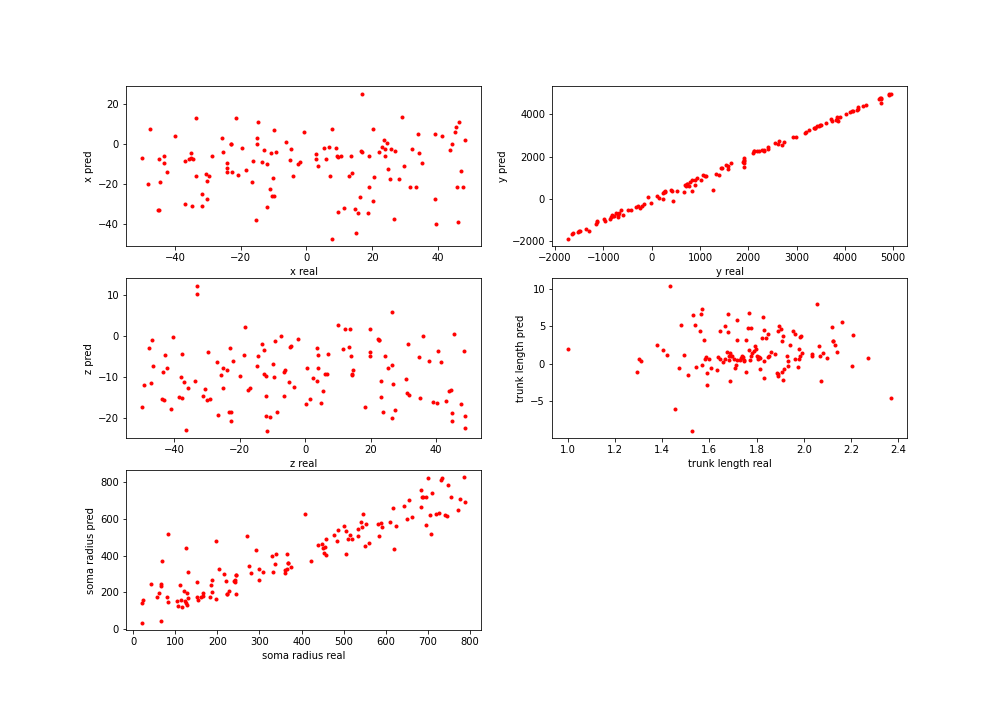

In [17]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))

ax_x = plt.subplot(321)
ax_x.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_x.set_xlabel('x real')
ax_x.set_ylabel('x pred')

ax_y = plt.subplot(322)
ax_y.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_y.set_xlabel('y real')
ax_y.set_ylabel('y pred')

ax_z = plt.subplot(323)
ax_z.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_z.set_xlabel('z real')
ax_z.set_ylabel('z pred')

ax_t = plt.subplot(324)
ax_t.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_t.set_xlabel('trunk length real')
ax_t.set_ylabel('trunk length pred')

ax_s = plt.subplot(325)
ax_s.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_s.set_xlabel('soma radius real')
ax_s.set_ylabel('soma radius pred')

plt.show()

<IPython.core.display.Javascript object>


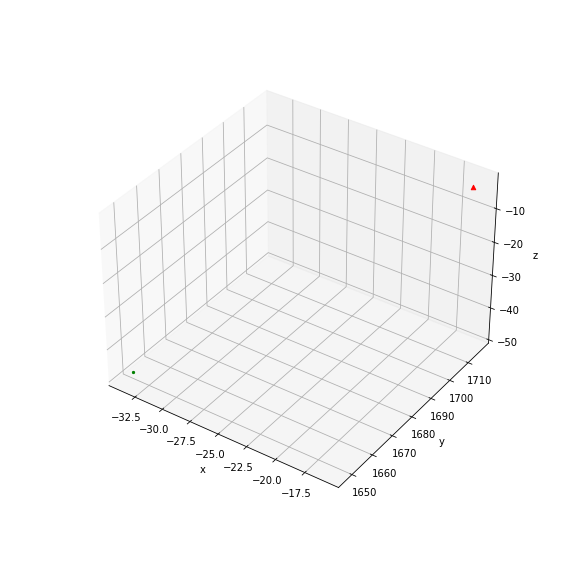

In [10]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()